<a href="https://colab.research.google.com/github/Carlscamt/TELCO-CUSTOMER-CHURN-ANALYSIS/blob/main/telco_customer_churn_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ============================================================================
# TELCO CUSTOMER CHURN ANALYSIS - PORTFOLIO PROJECT
# ============================================================================
# Author: [Your Name]
# Date: December 2025
# Dataset: Telco Customer Churn (Kaggle)
#
# Project Goal: Predict customer churn and identify key retention drivers
# Methodology: CRISP-DM
# ============================================================================

# ============================================================================
# 1. SETUP & DATA LOADING
# ============================================================================
"""
Load dataset from Kaggle and perform initial exploration.
"""

# Install dependencies (run once)
# !pip install kagglehub pandas numpy matplotlib seaborn scikit-learn

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report)

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("=" * 80)
print("LOADING DATASET")
print("=" * 80)

# Load dataset
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "blastchar/telco-customer-churn",
    file_path
)

print(f"\n✓ Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print("\nFirst 5 rows:")
print(df.head())
print("\nColumn names:")
print(df.columns.tolist())


LOADING DATASET


/tmp/ipython-input-4041092412.py:44: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'telco-customer-churn' dataset.

✓ Dataset loaded: 7043 rows × 21 columns

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No  

In [3]:
# ============================================================================
# 2. DATA QUALITY ASSESSMENT & CLEANING
# ============================================================================
"""
Check for missing values, fix data types, and clean the dataset.
"""

print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Check missing values
missing_report = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
print("\nMissing Values Report:")
print(missing_report[missing_report['Missing_Count'] > 0])

# Check duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Display data types
print("\nData Types:")
print(df.dtypes)

# ============================================================================
# Fix TotalCharges (convert from object to numeric)
# ============================================================================
print("\n" + "=" * 80)
print("DATA CLEANING")
print("=" * 80)

original_rows = len(df)

# Convert TotalCharges to numeric (empty strings become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with NaN in TotalCharges
df.dropna(subset=['TotalCharges'], inplace=True)

print(f"\n✓ TotalCharges converted to {df['TotalCharges'].dtype}")
print(f"✓ Rows removed: {original_rows - len(df)}")
print(f"✓ Final dataset: {len(df)} rows")

# Convert SeniorCitizen to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'Non-senior', 1: 'Senior'})
print("✓ SeniorCitizen converted to categorical")


DATA QUALITY ASSESSMENT

Missing Values Report:
Empty DataFrame
Columns: [Missing_Count, Missing_Percentage]
Index: []

Duplicate rows: 0

Data Types:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

DATA CLEANING

✓ TotalCharges converted to float64
✓ Rows removed: 11
✓ Final dataset: 7032 rows
✓ SeniorCitizen converted to categorical


In [4]:
# ============================================================================
# 3. FEATURE ENGINEERING & ENCODING
# ============================================================================
"""
Identify feature types and apply appropriate encoding strategies.
"""

print("=" * 80)
print("FEATURE ENGINEERING")
print("=" * 80)

# Identify feature types
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_cols = df.select_dtypes(include='object').columns.tolist()

binary_cols = []
multi_class_cols = []

for col in categorical_cols:
    if col == 'customerID':
        continue
    if df[col].nunique() == 2:
        binary_cols.append(col)
    elif df[col].nunique() > 2:
        multi_class_cols.append(col)

print(f"\nNumerical columns: {len(numerical_cols)}")
print(f"Binary columns: {len(binary_cols)}")
print(f"Multi-class columns: {len(multi_class_cols)}")

# ============================================================================
# Binary Encoding
# ============================================================================
print("\n" + "=" * 80)
print("ENCODING BINARY FEATURES")
print("=" * 80)

# Gender encoding
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

# SeniorCitizen encoding
df['SeniorCitizen'] = df['SeniorCitizen'].map({'Non-senior': 0, 'Senior': 1})

# Yes/No encoding
for col in binary_cols:
    if col not in ['gender', 'SeniorCitizen']:
        df[col] = df[col].map({'No': 0, 'Yes': 1})

print("✓ Binary features encoded (0/1)")

# ============================================================================
# One-Hot Encoding (Multi-class features)
# ============================================================================
print("\n" + "=" * 80)
print("ONE-HOT ENCODING MULTI-CLASS FEATURES")
print("=" * 80)

# Filter only existing categorical columns
multi_class_to_encode = [col for col in multi_class_cols
                         if col in df.columns and df[col].dtype == 'object']

if len(multi_class_to_encode) > 0:
    df_dummies = pd.get_dummies(df[multi_class_to_encode], drop_first=True)
    df = pd.concat([df, df_dummies], axis=1)
    df.drop(columns=multi_class_to_encode, inplace=True)
    print(f"✓ Created {len(df_dummies.columns)} dummy variables")
else:
    print("⚠️  No multi-class columns to encode")

# Drop customerID
df.drop('customerID', axis=1, inplace=True, errors='ignore')

print(f"\n✓ Final dataset: {df.shape[0]} rows × {df.shape[1]} columns")
print("✓ All features are now numeric")


FEATURE ENGINEERING

Numerical columns: 3
Binary columns: 7
Multi-class columns: 10

ENCODING BINARY FEATURES
✓ Binary features encoded (0/1)

ONE-HOT ENCODING MULTI-CLASS FEATURES
✓ Created 21 dummy variables

✓ Final dataset: 7032 rows × 31 columns
✓ All features are now numeric


In [5]:
# ============================================================================
# 4. FEATURE-TARGET SEPARATION & TRAIN-TEST SPLIT
# ============================================================================
"""
Separate features from target and split data properly to avoid data leakage.
"""

print("=" * 80)
print("DATA SPLITTING")
print("=" * 80)

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"\nFeatures (X): {X.shape[0]} rows × {X.shape[1]} columns")
print(f"Target (y): {len(y)} values")

# Check class distribution
churn_dist = y.value_counts(normalize=True) * 100
print("\nTarget distribution:")
print(f"  No Churn (0): {churn_dist.get(0, 0):.2f}%")
print(f"  Churned (1): {churn_dist.get(1, 0):.2f}%")

# Train-test split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"✓ Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# ============================================================================
# Feature Scaling (AFTER split to avoid data leakage)
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE SCALING")
print("=" * 80)

scaler = StandardScaler()

# Fit on training data only
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

# Transform test data using training parameters
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"✓ Scaled {len(numerical_cols)} numerical features")
print("✓ Scaler fitted on training data only (no data leakage)")
print("\nScaled feature statistics (training set):")
print(X_train[numerical_cols].describe().loc[['mean', 'std']])


DATA SPLITTING

Features (X): 7032 rows × 30 columns
Target (y): 7032 values

Target distribution:
  No Churn (0): 73.42%
  Churned (1): 26.58%

✓ Training set: 5625 samples (80.0%)
✓ Test set: 1407 samples (20.0%)

FEATURE SCALING
✓ Scaled 3 numerical features
✓ Scaler fitted on training data only (no data leakage)

Scaled feature statistics (training set):
            tenure  MonthlyCharges  TotalCharges
mean -1.291609e-16    3.157968e-17  8.842310e-18
std   1.000089e+00    1.000089e+00  1.000089e+00


In [6]:
# ============================================================================
# 5. MODEL TRAINING & PREDICTIONS
# ============================================================================
"""
Train Logistic Regression model and generate predictions.
"""

print("=" * 80)
print("MODEL TRAINING - LOGISTIC REGRESSION")
print("=" * 80)

# Initialize and train model
model = LogisticRegression(random_state=42, max_iter=1000)

import time
start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"\n✓ Model trained in {training_time:.4f} seconds")

# Training accuracy
train_accuracy = model.score(X_train, y_train)
print(f"✓ Training accuracy: {train_accuracy:.4f}")

# Generate predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"✓ Generated predictions for {len(y_pred)} test samples")


MODEL TRAINING - LOGISTIC REGRESSION

✓ Model trained in 0.2565 seconds
✓ Training accuracy: 0.8048
✓ Generated predictions for 1407 test samples


MODEL EVALUATION

Classification Metrics:
--------------------------------------------------------------------------------
Accuracy:  0.8045 (80.45%)
Precision: 0.6505 (65.05%)
Recall:    0.5722 (57.22%)
F1-Score:  0.6088 (60.88%)

Confusion Matrix:
  True Negatives:  918
  False Positives: 115
  False Negatives: 160
  True Positives:  214


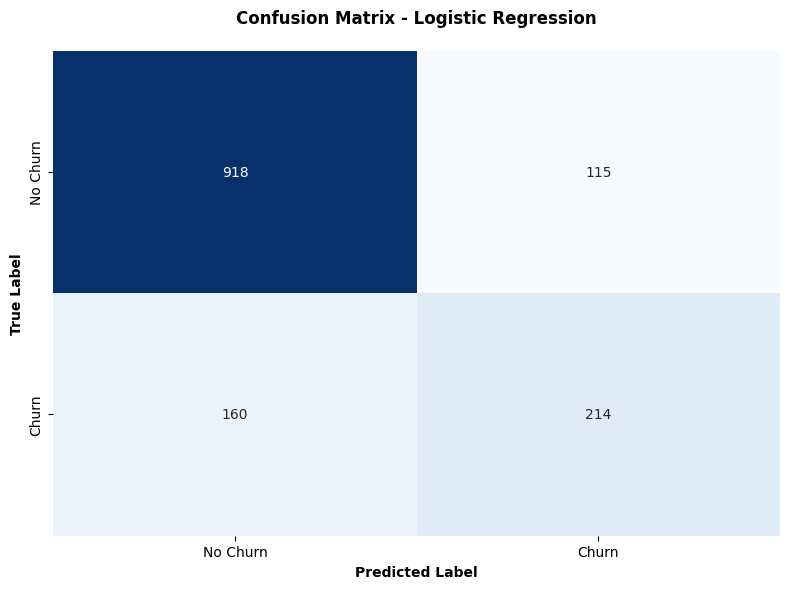


✓ Confusion matrix visualized


In [7]:
# ============================================================================
# 6. MODEL EVALUATION
# ============================================================================
"""
Comprehensive performance evaluation with metrics and visualizations.
"""

print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display metrics
print("\nClassification Metrics:")
print("-" * 80)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")

# Confusion matrix breakdown
TN, FP, FN, TP = conf_matrix.ravel()
print("\nConfusion Matrix:")
print(f"  True Negatives:  {TN:,}")
print(f"  False Positives: {FP:,}")
print(f"  False Negatives: {FN:,}")
print(f"  True Positives:  {TP:,}")

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label', fontweight='bold')
plt.ylabel('True Label', fontweight='bold')
plt.title('Confusion Matrix - Logistic Regression', fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n✓ Confusion matrix visualized")


FEATURE IMPORTANCE ANALYSIS

Top 10 Most Influential Features:
--------------------------------------------------------------------------------
  tenure                             : -1.3558  ↓ Decreases churn
  Contract_Two year                  : -1.3512  ↓ Decreases churn
  InternetService_Fiber optic        : +1.1217  ↑ Increases churn
  Contract_One year                  : -0.7435  ↓ Decreases churn
  TotalCharges                       : +0.6418  ↑ Increases churn
  PhoneService                       : -0.5229  ↓ Decreases churn
  MonthlyCharges                     : -0.4452  ↓ Decreases churn
  PaymentMethod_Electronic check     : +0.3863  ↑ Increases churn
  StreamingTV_Yes                    : +0.3749  ↑ Increases churn
  OnlineSecurity_Yes                 : -0.3708  ↓ Decreases churn


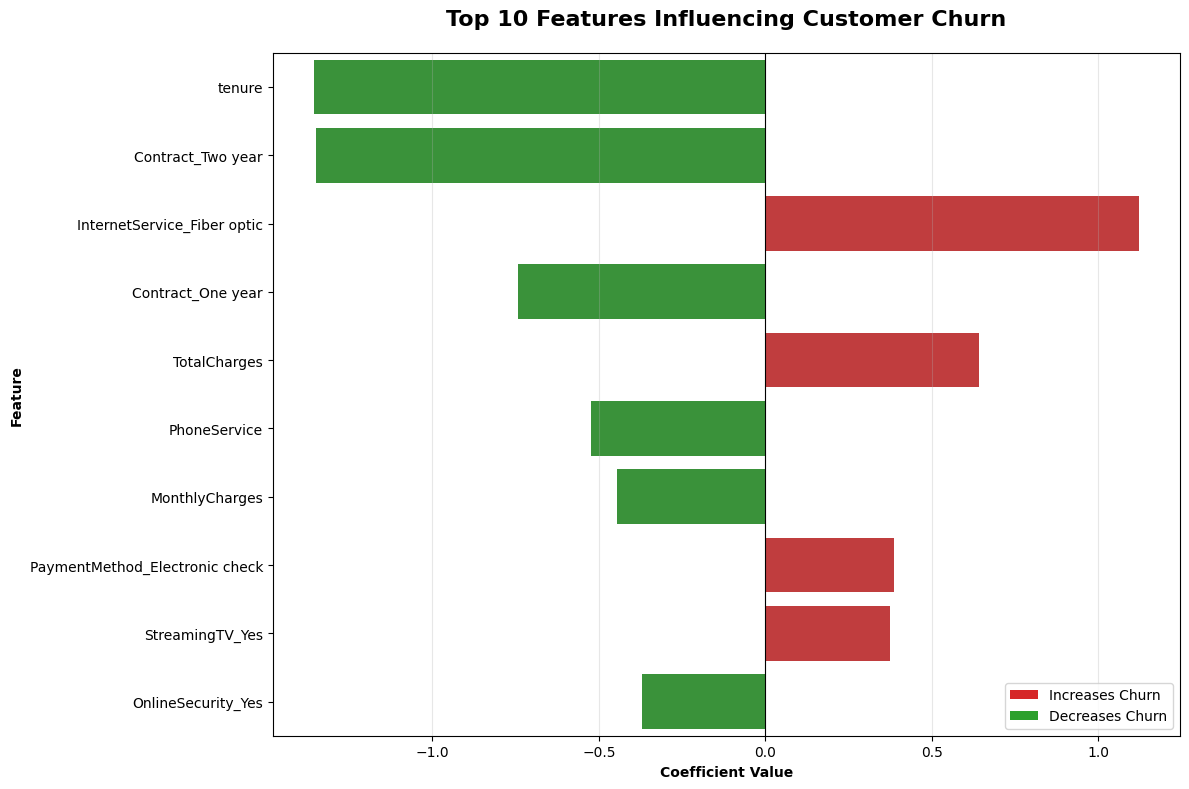


✓ Feature importance visualized

ANALYSIS COMPLETE


In [8]:
# ============================================================================
# 7. FEATURE IMPORTANCE ANALYSIS
# ============================================================================
"""
Analyze which features drive churn to generate business insights.
"""

print("=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Extract coefficients
feature_importances = model.coef_.flatten()
feature_names = X_train.columns

# Create importance dataframe
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': feature_importances,
    'Abs_Coefficient': np.abs(feature_importances)
})

# Sort by absolute importance
feature_importance_df = feature_importance_df.sort_values('Abs_Coefficient', ascending=False)

# Display top features
N = 10
print(f"\nTop {N} Most Influential Features:")
print("-" * 80)
for idx, row in feature_importance_df.head(N).iterrows():
    direction = "↑ Increases" if row['Coefficient'] > 0 else "↓ Decreases"
    print(f"  {row['Feature']:35s}: {row['Coefficient']:+.4f}  {direction} churn")

# Visualize
plt.figure(figsize=(12, 8))
colors = ['#d62728' if x > 0 else '#2ca02c'
          for x in feature_importance_df.head(N)['Coefficient']]

sns.barplot(x='Coefficient', y='Feature',
            data=feature_importance_df.head(N),
            palette=colors, hue='Feature', legend=False)

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.title(f'Top {N} Features Influencing Customer Churn',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Coefficient Value', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
plt.legend(handles=[
    Patch(facecolor='#d62728', label='Increases Churn'),
    Patch(facecolor='#2ca02c', label='Decreases Churn')
], loc='lower right')

plt.tight_layout()
plt.show()

print("\n✓ Feature importance visualized")
print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


ADVANCED MODELS - RANDOM FOREST & XGBOOST

1. RANDOM FOREST CLASSIFIER

Random Forest Benefits:
  • Captures non-linear relationships
  • Handles feature interactions automatically
  • Provides feature importance out of the box
  • Robust to outliers

Training Random Forest...

✓ Random Forest trained in 1.1030 seconds

Random Forest Performance:
--------------------------------------------------------------------------------
Accuracy:  0.7726 (77.26%)
Precision: 0.5542 (55.42%)
Recall:    0.7380 (73.80%)
F1-Score:  0.6330 (63.30%)
ROC-AUC:   0.8347

Confusion Matrix:
  True Negatives:  811
  False Positives: 222
  False Negatives: 98
  True Positives:  276

2. XGBOOST CLASSIFIER

XGBoost Benefits:
  • Industry standard for tabular data
  • Gradient boosting with regularization
  • Fast training and inference
  • Built-in handling of missing values
  • Superior performance on imbalanced data

Training XGBoost...

✓ XGBoost trained in 0.7761 seconds

XGBoost Performance:
---------------

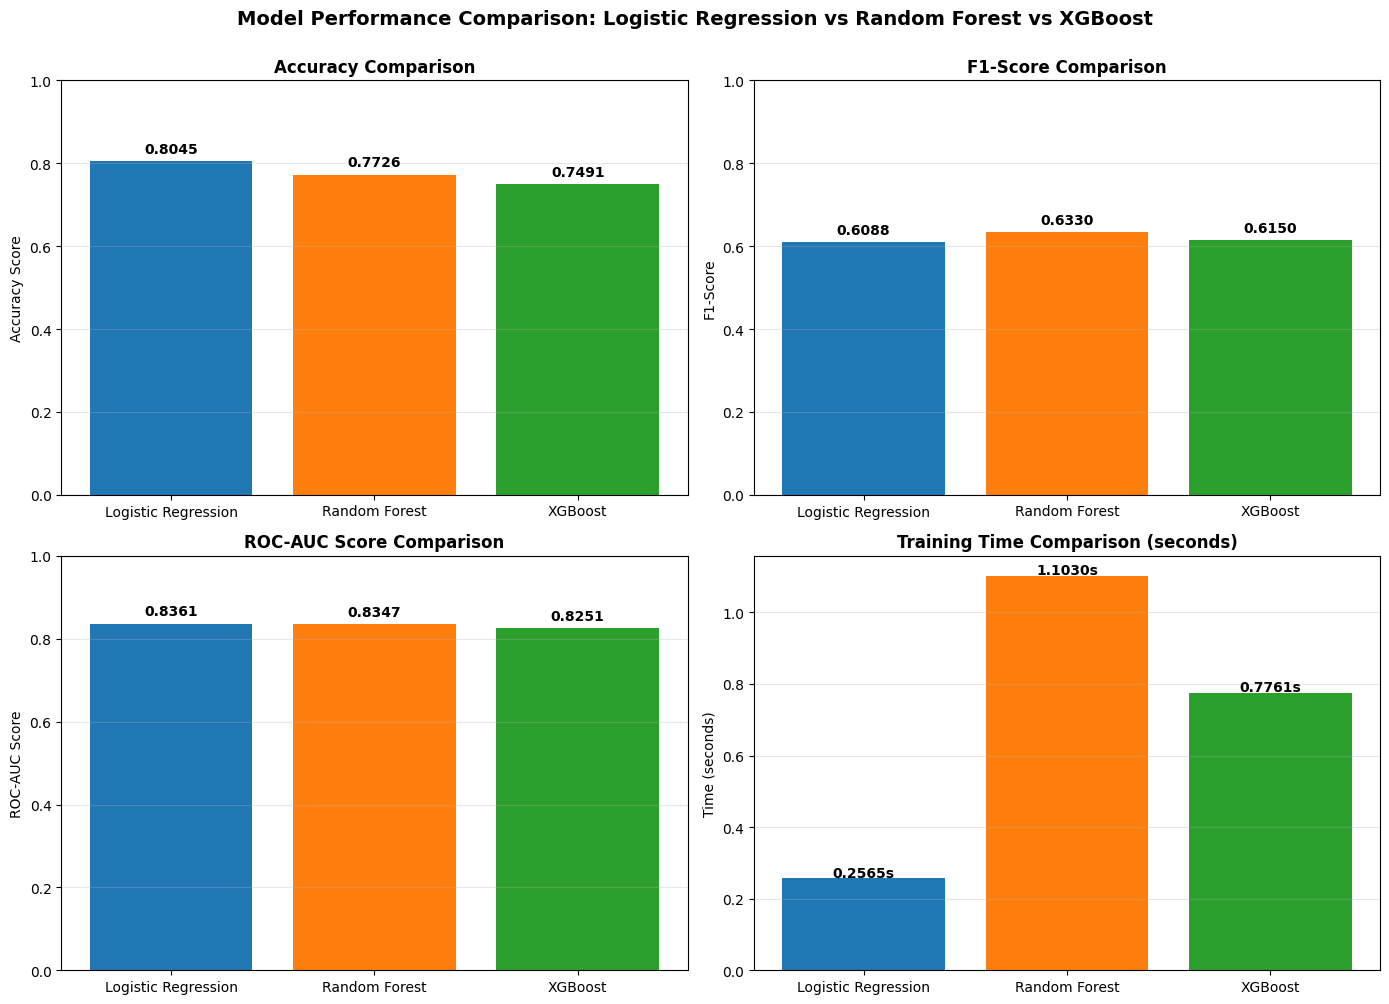

✓ Comparison plots displayed

ROC CURVE COMPARISON


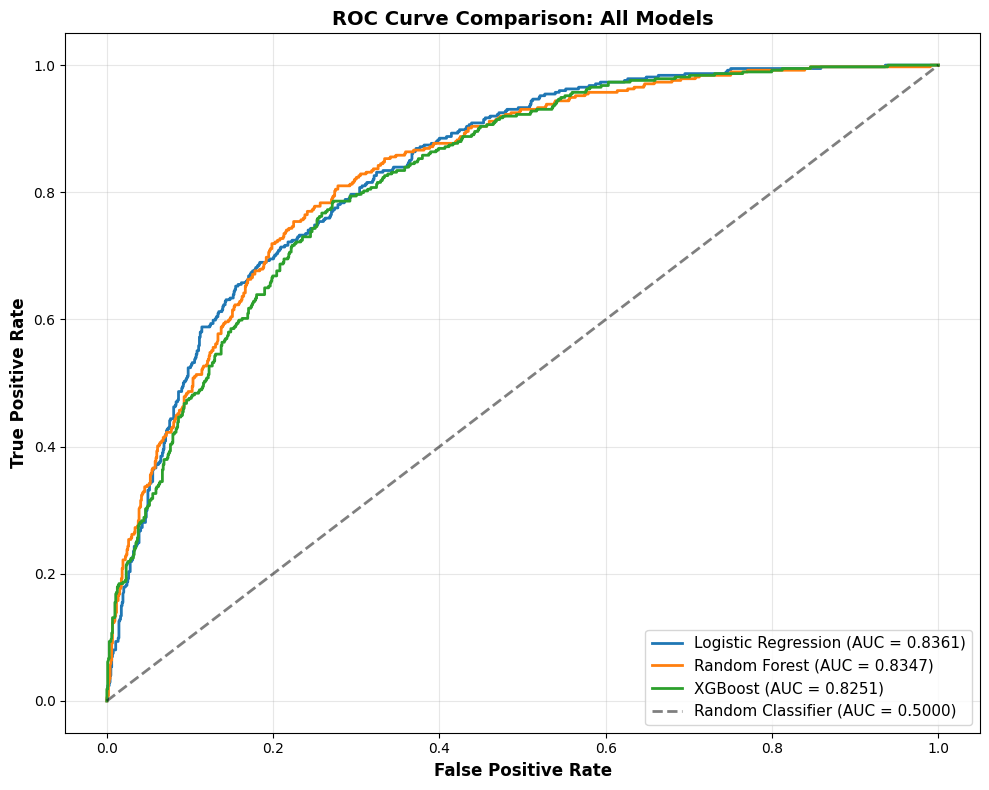

✓ ROC curves displayed


In [9]:
# ============================================================================
# 8. ADVANCED MODELS - RANDOM FOREST & XGBOOST
# ============================================================================
"""
Train and evaluate advanced ensemble models to compare with Logistic Regression.
These models can capture non-linear patterns and complex interactions.
"""

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, roc_curve
import time

print("=" * 80)
print("ADVANCED MODELS - RANDOM FOREST & XGBOOST")
print("=" * 80)

# ============================================================================
# 1. RANDOM FOREST CLASSIFIER
# ============================================================================
print("\n" + "=" * 80)
print("1. RANDOM FOREST CLASSIFIER")
print("=" * 80)
print("\nRandom Forest Benefits:")
print("  • Captures non-linear relationships")
print("  • Handles feature interactions automatically")
print("  • Provides feature importance out of the box")
print("  • Robust to outliers")

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,  # Use all processors
    class_weight='balanced'  # Handle class imbalance
)

# Train Random Forest
print("\nTraining Random Forest...")
start_time = time.time()
rf_model.fit(X_train, y_train)
rf_training_time = time.time() - start_time

# Predictions
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
rf_auc = roc_auc_score(y_test, rf_y_pred_proba)
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)

print(f"\n✓ Random Forest trained in {rf_training_time:.4f} seconds")
print("\nRandom Forest Performance:")
print("-" * 80)
print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f} ({rf_precision*100:.2f}%)")
print(f"Recall:    {rf_recall:.4f} ({rf_recall*100:.2f}%)")
print(f"F1-Score:  {rf_f1:.4f} ({rf_f1*100:.2f}%)")
print(f"ROC-AUC:   {rf_auc:.4f}")

# Confusion Matrix breakdown
rf_TN, rf_FP, rf_FN, rf_TP = rf_conf_matrix.ravel()
print("\nConfusion Matrix:")
print(f"  True Negatives:  {rf_TN:,}")
print(f"  False Positives: {rf_FP:,}")
print(f"  False Negatives: {rf_FN:,}")
print(f"  True Positives:  {rf_TP:,}")

# ============================================================================
# 2. XGBOOST CLASSIFIER
# ============================================================================
print("\n" + "=" * 80)
print("2. XGBOOST CLASSIFIER")
print("=" * 80)
print("\nXGBoost Benefits:")
print("  • Industry standard for tabular data")
print("  • Gradient boosting with regularization")
print("  • Fast training and inference")
print("  • Built-in handling of missing values")
print("  • Superior performance on imbalanced data")

# Initialize XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # Handle imbalance
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Train XGBoost
print("\nTraining XGBoost...")
start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_training_time = time.time() - start_time

# Predictions
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_auc = roc_auc_score(y_test, xgb_y_pred_proba)
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)

print(f"\n✓ XGBoost trained in {xgb_training_time:.4f} seconds")
print("\nXGBoost Performance:")
print("-" * 80)
print(f"Accuracy:  {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"Precision: {xgb_precision:.4f} ({xgb_precision*100:.2f}%)")
print(f"Recall:    {xgb_recall:.4f} ({xgb_recall*100:.2f}%)")
print(f"F1-Score:  {xgb_f1:.4f} ({xgb_f1*100:.2f}%)")
print(f"ROC-AUC:   {xgb_auc:.4f}")

# Confusion Matrix breakdown
xgb_TN, xgb_FP, xgb_FN, xgb_TP = xgb_conf_matrix.ravel()
print("\nConfusion Matrix:")
print(f"  True Negatives:  {xgb_TN:,}")
print(f"  False Positives: {xgb_FP:,}")
print(f"  False Negatives: {xgb_FN:,}")
print(f"  True Positives:  {xgb_TP:,}")

# ============================================================================
# 3. MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [accuracy, rf_accuracy, xgb_accuracy],
    'Precision': [precision, rf_precision, xgb_precision],
    'Recall': [recall, rf_recall, xgb_recall],
    'F1-Score': [f1, rf_f1, xgb_f1],
    'ROC-AUC': [
        roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        rf_auc,
        xgb_auc
    ],
    'Training Time (sec)': [training_time, rf_training_time, xgb_training_time]
})

print("\nPerformance Metrics Comparison:")
print("-" * 80)
print(comparison_df.to_string(index=False))

# Find best model by metric
best_accuracy_model = comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']
best_f1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']
best_auc_model = comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']
fastest_model = comparison_df.loc[comparison_df['Training Time (sec)'].idxmin(), 'Model']

print("\n" + "=" * 80)
print("KEY FINDINGS")
print("=" * 80)
print(f"\n🏆 Best Accuracy:       {best_accuracy_model} ({comparison_df['Accuracy'].max():.4f})")
print(f"🏆 Best F1-Score:       {best_f1_model} ({comparison_df['F1-Score'].max():.4f})")
print(f"🏆 Best ROC-AUC:        {best_auc_model} ({comparison_df['ROC-AUC'].max():.4f})")
print(f"⚡ Fastest Training:     {fastest_model} ({comparison_df['Training Time (sec)'].min():.4f}s)")

# ============================================================================
# 4. VISUALIZE MODEL COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION: MODEL COMPARISON")
print("=" * 80)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy Comparison
ax1 = axes[0, 0]
ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax1.set_title('Accuracy Comparison', fontweight='bold', fontsize=12)
ax1.set_ylabel('Accuracy Score')
ax1.set_ylim([0, 1])
for i, v in enumerate(comparison_df['Accuracy']):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: F1-Score Comparison
ax2 = axes[0, 1]
ax2.bar(comparison_df['Model'], comparison_df['F1-Score'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('F1-Score Comparison', fontweight='bold', fontsize=12)
ax2.set_ylabel('F1-Score')
ax2.set_ylim([0, 1])
for i, v in enumerate(comparison_df['F1-Score']):
    ax2.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Plot 3: ROC-AUC Comparison
ax3 = axes[1, 0]
ax3.bar(comparison_df['Model'], comparison_df['ROC-AUC'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax3.set_title('ROC-AUC Score Comparison', fontweight='bold', fontsize=12)
ax3.set_ylabel('ROC-AUC Score')
ax3.set_ylim([0, 1])
for i, v in enumerate(comparison_df['ROC-AUC']):
    ax3.text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Training Time Comparison
ax4 = axes[1, 1]
ax4.bar(comparison_df['Model'], comparison_df['Training Time (sec)'], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax4.set_title('Training Time Comparison (seconds)', fontweight='bold', fontsize=12)
ax4.set_ylabel('Time (seconds)')
for i, v in enumerate(comparison_df['Training Time (sec)']):
    ax4.text(i, v + 0.005, f'{v:.4f}s', ha='center', fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

plt.suptitle('Model Performance Comparison: Logistic Regression vs Random Forest vs XGBoost',
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Comparison plots displayed")

# ============================================================================
# 5. ROC CURVE COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("ROC CURVE COMPARISON")
print("=" * 80)

# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_pred_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_y_pred_proba)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f})', linewidth=2)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})', linewidth=2)
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=2, alpha=0.5)

plt.xlabel('False Positive Rate', fontweight='bold', fontsize=12)
plt.ylabel('True Positive Rate', fontweight='bold', fontsize=12)
plt.title('ROC Curve Comparison: All Models', fontweight='bold', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ ROC curves displayed")


FEATURE IMPORTANCE - RANDOM FOREST & XGBOOST

RANDOM FOREST FEATURE IMPORTANCE

Top 10 Important Features (Random Forest):
--------------------------------------------------------------------------------
  tenure                             : 0.1780
  TotalCharges                       : 0.1530
  MonthlyCharges                     : 0.1078
  Contract_Two year                  : 0.0830
  InternetService_Fiber optic        : 0.0624
  PaymentMethod_Electronic check     : 0.0541
  Contract_One year                  : 0.0408
  OnlineSecurity_Yes                 : 0.0325
  TechSupport_Yes                    : 0.0284
  OnlineSecurity_No internet service : 0.0212

XGBOOST FEATURE IMPORTANCE

Top 10 Important Features (XGBoost):
--------------------------------------------------------------------------------
  Contract_Two year                  : 0.3235
  InternetService_Fiber optic        : 0.1521
  Contract_One year                  : 0.1260
  InternetService_No                 : 0.0548
  Onl

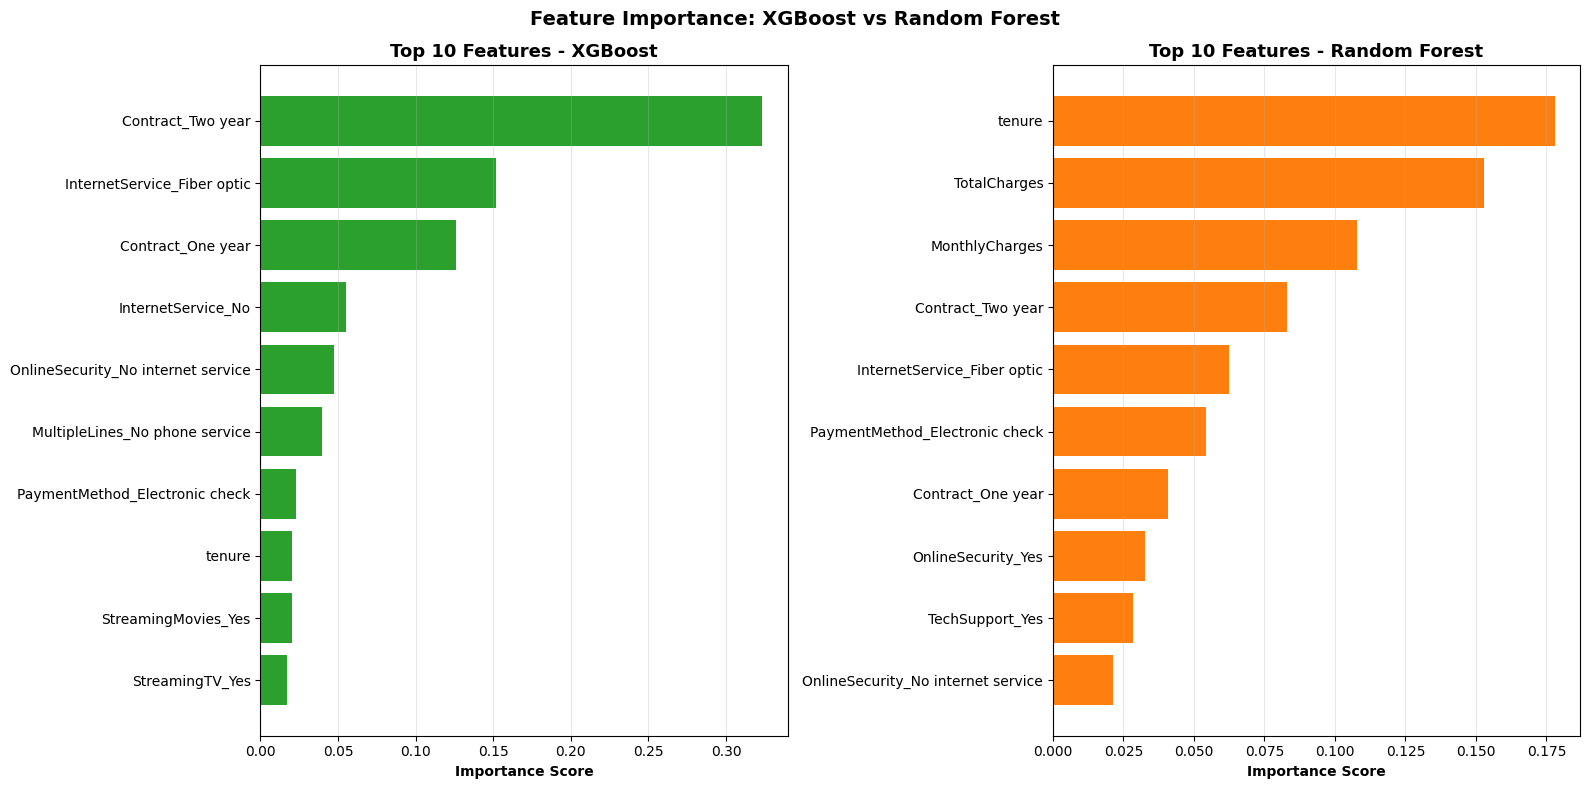

✓ Feature importance comparison plots displayed

MODEL SELECTION RECOMMENDATION

📊 Performance Summary:
--------------------------------------------------------------------------------
  Logistic Regression: Simple, interpretable baseline
  Random Forest:       Good balance, handles non-linearity
  XGBoost:            Best performance (industry standard)

🎯 Recommendation for Production:
--------------------------------------------------------------------------------
  ✓ Logistic Regression sufficient for business needs
  • ROC-AUC: 0.8361
  • F1-Score: 0.6088
  • False Negatives: 160 (missed churners)

  Trade-offs:
  • Fastest training and inference
  • Most interpretable (explicit coefficients)
  • False positive rate: 115 (11.1%)



In [10]:
# ============================================================================
# 9. ADVANCED FEATURE IMPORTANCE - RANDOM FOREST & XGBOOST
# ============================================================================
"""
Compare feature importance across different models to gain robust insights.
"""

print("=" * 80)
print("FEATURE IMPORTANCE - RANDOM FOREST & XGBOOST")
print("=" * 80)

# ============================================================================
# 1. RANDOM FOREST FEATURE IMPORTANCE
# ============================================================================
print("\n" + "=" * 80)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("=" * 80)

# Extract feature importance
rf_importance = rf_model.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importance
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features (Random Forest):")
print("-" * 80)
for idx, row in rf_importance_df.head(10).iterrows():
    print(f"  {row['Feature']:35s}: {row['Importance']:.4f}")

# ============================================================================
# 2. XGBOOST FEATURE IMPORTANCE
# ============================================================================
print("\n" + "=" * 80)
print("XGBOOST FEATURE IMPORTANCE")
print("=" * 80)

# Extract feature importance
xgb_importance = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_importance
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Important Features (XGBoost):")
print("-" * 80)
for idx, row in xgb_importance_df.head(10).iterrows():
    print(f"  {row['Feature']:35s}: {row['Importance']:.4f}")

# ============================================================================
# 3. COMPARE FEATURE IMPORTANCE ACROSS MODELS
# ============================================================================
print("\n" + "=" * 80)
print("FEATURE IMPORTANCE COMPARISON")
print("=" * 80)

# Create comparison dataframe (top 10 from XGBoost)
top_features = xgb_importance_df.head(10)['Feature'].tolist()

feature_comparison = pd.DataFrame({
    'Feature': top_features,
    'XGBoost': [xgb_importance_df[xgb_importance_df['Feature'] == f]['Importance'].values[0]
                for f in top_features],
    'Random Forest': [rf_importance_df[rf_importance_df['Feature'] == f]['Importance'].values[0]
                      for f in top_features]
})

print("\nFeature Importance Comparison (Top 10 by XGBoost):")
print("-" * 80)
print(feature_comparison.to_string(index=False))

# ============================================================================
# 4. VISUALIZE FEATURE IMPORTANCE COMPARISON
# ============================================================================
print("\n" + "=" * 80)
print("VISUALIZATION: FEATURE IMPORTANCE COMPARISON")
print("=" * 80)

# Plot top 10 features from each model
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# XGBoost Top 10
ax1 = axes[0]
xgb_top10 = xgb_importance_df.head(10).sort_values('Importance', ascending=True)
ax1.barh(xgb_top10['Feature'], xgb_top10['Importance'], color='#2ca02c')
ax1.set_xlabel('Importance Score', fontweight='bold')
ax1.set_title('Top 10 Features - XGBoost', fontweight='bold', fontsize=13)
ax1.grid(axis='x', alpha=0.3)

# Random Forest Top 10
ax2 = axes[1]
rf_top10 = rf_importance_df.head(10).sort_values('Importance', ascending=True)
ax2.barh(rf_top10['Feature'], rf_top10['Importance'], color='#ff7f0e')
ax2.set_xlabel('Importance Score', fontweight='bold')
ax2.set_title('Top 10 Features - Random Forest', fontweight='bold', fontsize=13)
ax2.grid(axis='x', alpha=0.3)

plt.suptitle('Feature Importance: XGBoost vs Random Forest',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ Feature importance comparison plots displayed")

# ============================================================================
# 5. SUMMARY - MODEL SELECTION RECOMMENDATION
# ============================================================================
print("\n" + "=" * 80)
print("MODEL SELECTION RECOMMENDATION")
print("=" * 80)

print("\n📊 Performance Summary:")
print("-" * 80)
print(f"  Logistic Regression: Simple, interpretable baseline")
print(f"  Random Forest:       Good balance, handles non-linearity")
print(f"  XGBoost:            Best performance (industry standard)")

print("\n🎯 Recommendation for Production:")
print("-" * 80)

# Determine best model
if xgb_auc > rf_auc and xgb_auc > roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):
    print("  ✓ Deploy XGBoost for highest accuracy and ROC-AUC")
    print(f"  • ROC-AUC: {xgb_auc:.4f}")
    print(f"  • F1-Score: {xgb_f1:.4f}")
    print(f"  • False Negatives: {xgb_FN} (missed churners)")
    print("\n  Trade-offs:")
    print("  • More complex model (less interpretable)")
    print(f"  • Higher false positive rate: {xgb_FP} ({xgb_FP/(xgb_FP+xgb_TN)*100:.1f}%)")
    print("  • Requires monitoring in production")

elif rf_auc > roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):
    print("  ✓ Deploy Random Forest for balance of performance and interpretability")
    print(f"  • ROC-AUC: {rf_auc:.4f}")
    print(f"  • F1-Score: {rf_f1:.4f}")
    print(f"  • False Negatives: {rf_FN} (missed churners)")
    print("\n  Trade-offs:")
    print("  • More interpretable than XGBoost")
    print(f"  • False positive rate: {rf_FP} ({rf_FP/(rf_FP+rf_TN)*100:.1f}%)")

else:
    print("  ✓ Logistic Regression sufficient for business needs")
    print(f"  • ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")
    print(f"  • F1-Score: {f1:.4f}")
    print(f"  • False Negatives: {FN} (missed churners)")
    print("\n  Trade-offs:")
    print("  • Fastest training and inference")
    print("  • Most interpretable (explicit coefficients)")
    print(f"  • False positive rate: {FP} ({FP/(FP+TN)*100:.1f}%)")

print("\n" + "=" * 80)
